In [1]:
import numpy as np
import pandas as pd
import time
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.models import load_model
from scipy import ndimage, misc
import gym
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
def process_obs(obs):
    obs = obs.max(axis=-1,keepdims=1)
    obs = obs.reshape((210,160))
    obs = misc.imresize(obs, (110,84))
    obs = obs[18:102,:,]
    obs = np.expand_dims(obs,2)
    obs = obs.astype('float32') / 255
    obs[obs > 0] = 1
    return obs

In [47]:
env = gym.make("Breakout-v0")
init = env.reset()

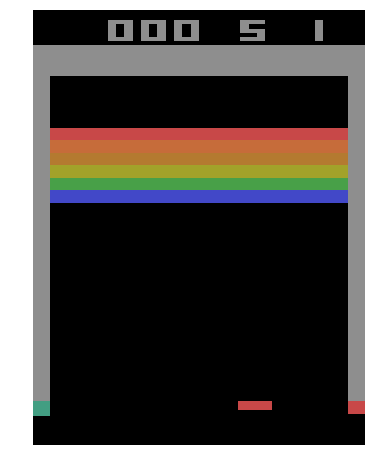

In [48]:
plot_state(init)

In [49]:
I = process_obs(init)

/home/sam.williams/python3.6/lib64/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [50]:
I.shape

(84, 84, 1)

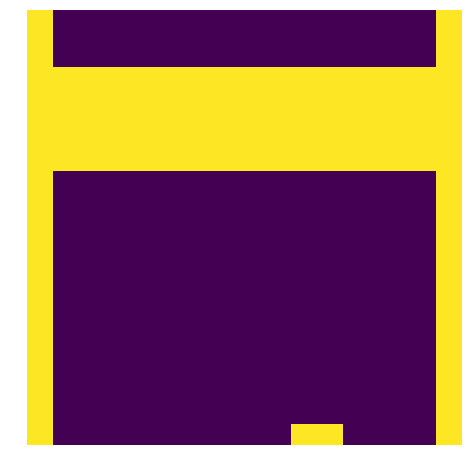

In [51]:
plot_state(I.reshape(84,84))

In [54]:
I.shape

(84, 84, 1)

In [55]:
env.action_space

Discrete(4)

In [56]:
env.observation_space.shape

(210, 160, 3)

In [15]:
inp = Input(shape=(84,84,1))
x = Conv2D(16, (8,8), strides=4, activation="relu", input_shape=(84,84,1))(inp)
x = Conv2D(32, (4,4), strides=2, activation="relu")(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.9, patience=2)]
model.compile(loss='mean_squared_error', optimizer='SGD', metrics=["mae"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 84, 84, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 16)        1040      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten_5 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1327616   
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 2052      
Total params: 1,338,932
Trainable params: 1,338,932
Non-trainable params: 0
_________________________________________________________________


In [12]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation = process_obs(observation)


episodes = 10000
epsilon = 0.5
gamma = 0.9
done = False

history = {}


for i in range(1, episodes):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...\n".format(i, episodes))
    
    history = {"input":[], "reward":[], "action": [], "Q":[]}
    sum = 0
    game = True
    while game:
        
        rand = np.random.uniform(0,1)
        if  rand < epsilon:
            action = env.action_space.sample()
        else:
            observation = np.expand_dims(observation,0)
            action = np.argmax(model.predict(observation))
          
        observation, reward, done, info = env.step(action)
        observation = process_obs(observation)
        
        history["input"].append(observation)
        history["action"].append(action)
        history["reward"].append(reward)
        sum += reward
        
        #time.sleep(0.001)
        #env.render()
        
        if done:
        
            Q = []
            for j,k in enumerate(history["reward"][::-1]):
                if j == 0:
                    val = np.array([[0, 0, 0, 0]])
                    val[0,history["action"][-1]] = k
                    Q.append(val)
                else:
                    val = np.array([[0, 0, 0, 0]])
                    val[0,history["action"][-1-j]] = k + gamma*Q[-1][0].sum()
                    Q.append(val)
            
            Q = np.array(Q[::-1])
            Q = Q.reshape(Q.shape[0],Q.shape[2])


            history["Q"] = Q 
            
            if sum < 4:
                observation = env.reset()
                observation = process_obs(observation)
                game = False
            else:
                print("Training the model...")
                
                history["input"] = np.array(history["input"])
                print(history["input"].shape)
                model.fit(history["input"], history["Q"], epochs = 4, batch_size=100, callbacks=callbacks_list)
                print("Total game score was: {}\n".format(sum))
            
                observation = env.reset()
                observation = process_obs(observation)
                #epsilon -= 0.01
                game = False
                             
        else:
            pass
            
         

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Welcome to AI Breakout!
Starting Game 1 of 5000...

Welcome to AI Breakout!
Starting Game 2 of 5000...

Welcome to AI Breakout!
Starting Game 3 of 5000...

Welcome to AI Breakout!
Starting Game 4 of 5000...

Welcome to AI Breakout!
Starting Game 5 of 5000...

Welcome to AI Breakout!
Starting Game 6 of 5000...

Welcome to AI Breakout!
Starting Game 7 of 5000...



KeyboardInterrupt: 

In [15]:
#model.predict(observation)

In [31]:
observation.shape

(84, 84, 1)

In [33]:
observation

array([[[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       ...,

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [255],
        [255],
        [255]],

       [[255],
        [255],
        [255],
        ...,
        [242],
        [242],
        [242]]], dtype=uint8)

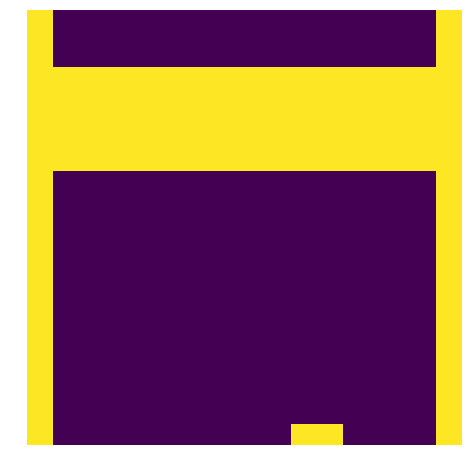

In [59]:
plot_state(observation.reshape((84,84)))

# Saving Model

In [60]:
#model.save("breakout-atari-rl.h5")

# Testing the Model

In [4]:
mod = load_model("breakout-atari-rl.h5")

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


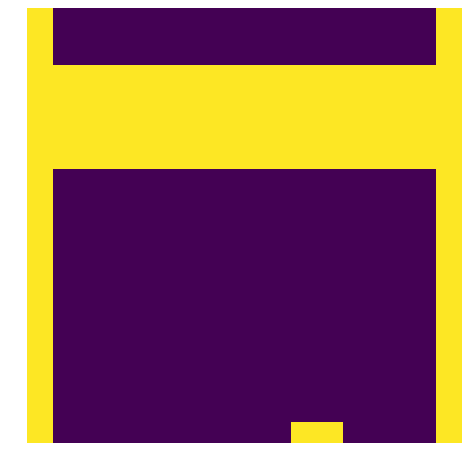

Welcome to AI Breakout!
Starting Game 1 of 20...
Total game score was: 3.0

Welcome to AI Breakout!
Starting Game 2 of 20...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 3 of 20...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 4 of 20...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 5 of 20...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 6 of 20...
Total game score was: 1.0

Welcome to AI Breakout!
Starting Game 7 of 20...
Total game score was: 3.0

Welcome to AI Breakout!
Starting Game 8 of 20...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 9 of 20...
Total game score was: 1.0

Welcome to AI Breakout!
Starting Game 10 of 20...
Total game score was: 1.0

Welcome to AI Breakout!
Starting Game 11 of 20...
Total game score was: 1.0

Welcome to AI Breakout!
Starting Game 12 of 20...
Total game score was: 1.0

Welcome to AI Breakout!
Starting Game 13 of 20...
Total game score was: 1.0

Welcome 

KeyboardInterrupt: 

In [5]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation = process_obs(observation)

plot_state(observation.reshape((84,84)))

episodes = 20
gamma = 0.9
done = False
epsilon = 0.2

history = {}


for i in range(1, episodes):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...".format(i, episodes))
    
    sum = 0
    game = True
    obs = []
    while game:
        
        if (len(obs) == 0):
            action = 1
        elif (len(obs) > 1) and (np.array_equal(obs[-1],obs[-2])):
            action = 1
        else:
            rand = np.random.uniform(0,1)
            if  rand < epsilon:
                action = env.action_space.sample()
            else:
                observation = np.expand_dims(observation,0)
                action = np.argmax(mod.predict(observation))
            
        #print(action)
        observation, reward, done, info = env.step(action)
        observation = process_obs(observation)
        obs.append(observation)

        sum += reward
        time.sleep(0.01)
        env.render()

        if done:
            print("Total game score was: {}\n".format(sum))
            observation = env.reset()
            observation = process_obs(observation)
            game = False
env.close()        

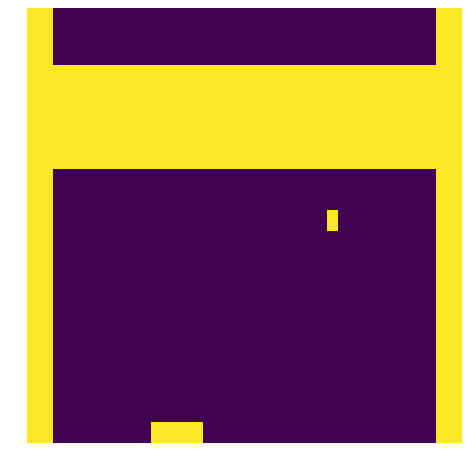

In [6]:
plot_state(observation.reshape((84,84)))

In [7]:
observation.shape

(84, 84, 1)